For the cosserat rod equations, there are two kinematic equations (one related to translations and another related to rotations) and two dynamic equations (again, one related to translations and another related to rotations). So we tackle this problem in increasing levels of complexity via these milestones:

1) first tackle translations (which are easier to implement) by testing the equations on an elastic beam that is fixed on one end and has a small axial force on the one end. Because the beam is elastic, and the axial force is small, the entire beam behaves like a spring. We can then plot look at how much the beam stretches, which should correspond with analytical spring equations. This is milestone 1.

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import time

# This class is not completely general: only supports uniform mass and single radius
class cosserat_rod:
    # initialize the rod
    def __init__(self, lock_e: bool, fix_to_wall: bool, n_elements: int = 100, tot_length = 3, rod_density = 5E3, 
                 rod_radius = 0.25, E = 1E6, G = 1E4, velocities = 0, internal_forces = 0):
        self.lock_e = lock_e
        self.fix_to_wall = fix_to_wall
        
        '''Set up quantities that describe the rod'''
        self.tot_length = tot_length
        self.G = G
        self.E = E
        self.n_elements = n_elements
        self.n_nodes = self.n_elements+1
        element_length = tot_length/n_elements
        
        # initially straight rod
        #self.positions = np.vstack((np.zeros((2,self.n_nodes)),np.arange(0.0, tot_length+element_length, element_length)))
        
        # initially v shaped rod at 45 degree angle
        self.positions = np.zeros((3, self.n_nodes))
        self.positions[2] = np.arange(0.0, (tot_length+element_length)*np.cos(np.pi/4), element_length*np.cos(np.pi/4))
        self.positions[0] = np.arange(0.0, (tot_length+element_length)*np.sin(np.pi/4), element_length*np.sin(np.pi/4))
        self.positions[0, int(self.n_nodes/2.0):] = -self.positions[0, int(self.n_nodes/2.0):] + tot_length*np.cos(np.pi/4)
        
        self.lengths_bold = self.positions[:, 1:] - self.positions[:, :-1]
        self.lengths_norm = np.linalg.norm(self.lengths_bold, axis=0, keepdims=True)
        self.reference_lengths_bold = self.positions[:, 1:] - self.positions[:, :-1]
        self.reference_lengths_norm = np.linalg.norm(self.reference_lengths_bold, axis=0, keepdims=True)
        
        self.directors = np.zeros((3, 3, self.n_elements))
        self.directors[2] = self.lengths_bold/self.lengths_norm
        self.directors[1] = [[0]*self.n_elements, [1]*self.n_elements, [0]*self.n_elements]
        self.directors[0] = np.transpose(np.cross(self.directors[1], self.directors[2], 0, 0))
        
        self.rod_area = np.pi*rod_radius*rod_radius
        self.areas = self.rod_area*np.ones(self.n_elements,)
        
        element_mass = rod_density*element_length*self.rod_area
        self.masses = element_mass*np.ones(self.n_nodes,)
        self.masses[0] *= 0.5
        self.masses[-1] *= 0.5
        
        '''Rotational stuff'''
        
        # moment of inertia about each director
        element_I = np.array([1/12 * element_mass * (3 * np.square(rod_radius) + np.square(element_length)), \
                     1/12 * element_mass * (3 * np.square(rod_radius) + np.square(element_length)), \
                     0.5 * element_mass * rod_radius * rod_radius])
                                        
        self.I_ref = np.zeros((3, self.n_elements))
        self.I_ref[0,:] = element_I[0]
        self.I_ref[1,:] = element_I[1]
        self.I_ref[2,:] = element_I[2]
        
        # Bend/twist matrix
        self.B_ref = np.zeros((3, 3, n_elements))
        self.J_ref = np.zeros((3, 3, n_elements))
        self.inv_J_ref = np.zeros((3, 3, n_elements))
        for idx in range(n_elements):
            self.B_ref[:, :, idx] = np.diag(element_I) * np.array([self.E, self.E, self.G])
            self.J_ref[:, :, idx] = np.diag(rod_density*self.reference_lengths_norm[:, idx]*self.I_ref[:, idx])
            self.inv_J_ref[:, :, idx] = np.linalg.inv(self.J_ref[:, :, idx]) # rather calculate this now
            
#         lengths_next = np.roll(self.lengths_bold, -1, 1)
#         self.D_ref = (lengths_next[:, :-1] + self.lengths_bold[:, :-1])/2

        lengths_next = np.roll(self.lengths_norm, -1, 1)
        B_next = np.roll(self.B_ref, -1, 2)
        
        self.D_ref = (lengths_next[:, :-1] + self.lengths_norm[:, :-1])/2
        
        # Need it in voronoi domain
        self.B_ref = (B_next[:, :, :-1] * lengths_next[:, :-1] + self.B_ref[:, :, :-1] * self.lengths_norm[:, :-1])/ (2*self.D_ref)    
        
        '''Set up quantities that will capture motion'''
        # This way of doing it is bad and should be fixed, will throw error if you try to input your own vals
        self.velocities = velocities if velocities else np.zeros((3, self.n_nodes)) 
        self.internal_forces = internal_forces if internal_forces else np.zeros((3, self.n_nodes))
        self.ang_vels = np.zeros((3, self.n_elements))
        
        self.dilatations = self.lengths_norm / self.reference_lengths_norm
        
        self.shear_stiffness_matrix = np.zeros((3, 3, n_elements)) # S
        alpha_c = 4.0 / 3.0
        self.shear_stiffness_matrix[0, 0, :] = alpha_c * self.G * self.areas # S1
        self.shear_stiffness_matrix[1, 1, :] = alpha_c * self.G * self.areas # S2
        self.shear_stiffness_matrix[2, 2, :] = self.E * self.areas # S2
        
        self.tangents = self.lengths_bold / self.lengths_norm 
        
        self.shear_stretch_strains = self.dilatations * self.tangents - self.directors[:, 2, :]
        
        # to get sigma in material frame
        self.shear_stretch_strains = np.einsum('ijk, jk-> ik', self.directors, self.shear_stretch_strains)

    def inverse_rotate(self, t_frameone, t_frametwo):
        # trying to make it work without looping through elements, so R has n_elem - 1 k dimension
        # this einsum is Q*R.T for two matrices Q and R
        R = np.einsum('ijk, ljk -> ilk', t_frametwo, t_frameone)
        
        angle = np.arccos((np.trace(R)-1.0)/2.0)
        K = (R-np.transpose(R, (1,0,2)))/(2.0*np.sin(angle))
        about = np.array([-K[1,2,:], K[0,2,:], -K[0,1,:]])        
        about = np.nan_to_num(about, 0)
        
        return about*angle
    
    def rotate_rodrigues(self, t_frame, t_angle, about=[0.0,0.0,1.0], rad=True):
        # Check if its in radian or degree
        # Default assumed to be rad
        if not rad:
            t_angle = np.deg2rad(t_angle)

        def normalize(v):
            """ Normalize a vector/ matrix """
            norm = np.linalg.norm(v, None, 0) # along directions
            # norm[np.isclose(norm, 0.0)] = 10000 # kind of a hack, makes anything near 0 really tiny
            return v / (norm + 1E-14)

        def skew_symmetrize(v):
            """ Generate an orthogonal matrix from vector elements"""
            # Hard coded. Others are more verbose or not worth it
            temp = np.zeros((3, 3, self.n_elements))
            for elem in range(self.n_elements):
                temp[:, :, elem] = [[0.0,-v[2, elem],v[1, elem]], [v[2, elem],0.0,-v[0, elem]], \
                                    [-v[1, elem],v[0, elem],0.0]]
            return temp
        

        # Convert about to np.array and normalize it
        about = normalize(np.array(about))

        # Form the 2D Euler rotation matrix
        c_angle = np.cos(t_angle)
        s_angle = np.sin(t_angle)

        # DS for 3D Euler rotation matrix
        # Composed of 2D matrices
        I = np.zeros((3, 3, self.n_elements))
        for idx in range(self.n_elements):
            I[:, :, idx] = np.eye(3)
        K_mat = skew_symmetrize(about)
        # rot_matrix = I + K_mat @ (s_angle * I + (1-c_angle)* K_mat)
        rot_matrix = I + (s_angle * K_mat + (1.0 - c_angle) * np.einsum('ijk, lik-> ljk', K_mat,  K_mat))   
        # print(rot_matrix, U_mat)

        return np.einsum('ijk, lik-> ljk', rot_matrix,  t_frame)

            
    def deltaH_operator(self, t_x): 
        n_pad = [(0,0)] * t_x.ndim
        n_pad[t_x.ndim - 1] = (0,1)
        temp = np.pad(t_x, n_pad, 'constant', constant_values=(0,0))
        return temp - np.roll(temp, 1, t_x.ndim - 1)
    
    def Ah_operator(self, t_x):        
        n_pad = [(0,0)] * t_x.ndim
        n_pad[t_x.ndim - 1] = (0,1)
        temp = np.pad(t_x, n_pad, 'constant', constant_values=(0,0))
        return (temp + np.roll(temp, 1, t_x.ndim - 1)) / 2
    
    # should be called after Newton2 updates all the class vars at dt/2 --- currently w_n is coming back incorrectly
    def Newton2Rot(self, temp_Q):        
        Q_next = np.roll(temp_Q, -1, 2)[:, :, :-1]
        
        self.kappa_ref = -self.inverse_rotate(temp_Q[:,:,:-1], Q_next) / self.D_ref 
        
        self.kappa_ref = np.nan_to_num(self.kappa_ref)
        
        # matrix vector product, 3 x n_elem-1 output
        BK_product = np.einsum('ijk, jk -> ik', self.B_ref, self.kappa_ref) 
        
        # 0 axis of inputs should be along directors, 1 is n_elem-1, output transposed to get dims back to 3 x n_elem-1
        KB_cross = np.transpose(np.cross(self.kappa_ref, BK_product, 0, 0))
        
        # bend twist internal couple, get these to be 3 x n_elem
        self.bend_twist_couple = self.deltaH_operator(BK_product) + self.Ah_operator(KB_cross*self.D_ref)
        
        # shear stretch internal couple
        # Q is 3 x 3 x n_elem, self. tangents is 3 x n_elem, output is 3 x n_elem
        Qt_product = np.einsum('ijk, jk-> ik', temp_Q, self.tangents)
        Ssigma_product = np.einsum('ijk, jk-> ik', self.shear_stiffness_matrix, self.shear_stretch_strains)
        # both 3 x n_elem, transpose is because cross gives n_elements x 3, I want opposite
        self.shear_stretch_couple = np.cross(Qt_product, Ssigma_product, axis = 0)*self.reference_lengths_norm
                                                   
        dwdt = np.einsum('ijk, jk-> ik', self.inv_J_ref, (self.bend_twist_couple + self.shear_stretch_couple + self.ext_couples))
        return dwdt
    
    # F = ma type calculations - key is to use position at half time step to recalc internal forces, then a
    def Newton2(self, temp_x):        
        # update vals to use force_rule at dt/2
        self.lengths_bold = temp_x[:, 1:] - temp_x[:, :-1]
        self.lengths_norm = np.linalg.norm(self.lengths_bold, axis=0, keepdims=True)

        self.dilatations = self.lengths_norm / self.reference_lengths_norm
        self.tangents = self.lengths_bold / self.lengths_norm
        
        self.shear_stretch_strains = self.dilatations * self.tangents - self.directors[2, :, :]
        
        # to get it in material frame
        # this einsum is matrix-vector multiplication for 3 x 3 x k and 3 x k
        self.shear_stretch_strains = np.einsum('ijk, jk-> ik', temp_Q, self.shear_stretch_strains)
        
        self.internal_forces = np.einsum('jil, jkl, kl -> il ', temp_Q, \
                                         self.shear_stiffness_matrix, self.shear_stretch_strains)
        
        node_forces = self.deltaH_operator(self.internal_forces)

        dvdt = (node_forces + self.ext_forces) / self.masses 
        return dvdt

    def position_verlet(self, dt, x, v, force_rule):
        temp_x = x + 0.5*dt*v
        v_n = v + dt * force_rule(temp_x)
        x_n = temp_x + 0.5 * dt * v_n
        return x_n, v_n
    
    def position_verletRot(self, dt, Q, w, force_rule):
        temp_rot_axis = -0.5*dt*w
        temp_Q = self.rotate_rodrigues(Q, np.linalg.norm(temp_rot_axis), temp_rot_axis)
        w_n = w + dt * force_rule(temp_Q)
        rot_axis = -w_n*0.5*dt
        Q_n = self.rotate_rodrigues(temp_Q, np.linalg.norm(rot_axis), rot_axis)
        return Q_n, w_n

    # run the simulation, specifying external conditions ** for now it's just for first benchmark
    def run(self, ext_forces, ext_couples, t_total = 100, dt = 3E-4):
        self.ext_forces = ext_forces
        self.ext_couples = ext_couples
        n_iterations = int(np.ceil(t_total/dt))
        
        self.position_history = np.zeros((3, self.n_nodes, n_iterations))
        self.position_history[:, :, 0] = self.positions
        self.vel_history = np.zeros((3, self.n_nodes, n_iterations))
        self.position_history[:, :, 0] = self.positions
        self.kappa_history = np.zeros((self.n_elements-1, n_iterations))
        self.omega_history = np.zeros((self.n_elements, n_iterations))
        self.director_history = np.zeros(n_iterations)
        self.length_history = np.zeros(n_iterations)
        for time_step in range(n_iterations):
            self.positions, self.velocities = self.position_verlet(dt, self.positions, self.velocities, self.Newton2)
            self.directors, self.ang_vels = self.position_verletRot(dt, self.directors, self.ang_vels, self.Newton2Rot)
            if self.lock_e:
                # constrain the first element to the wall
                self.positions[:,0] = np.zeros(3,)
                self.velocities[:, 0] = np.zeros(3,)

            self.position_history[:, :, time_step] = self.positions
            self.vel_history[:, :, time_step] = self.velocities
            self.kappa_history[:, time_step] = self.kappa_ref[1]
            self.omega_history[:, time_step] = self.ang_vels[1]
            self.director_history[time_step] = self.directors[2, 0, 0]
            self.length_history[time_step] = self.lengths_norm[0, 0]

        return (self.positions, self.position_history)         

array([[-0.        , -0.        ],
       [ 1.57079633,  1.57079633],
       [-0.        , -0.        ]])

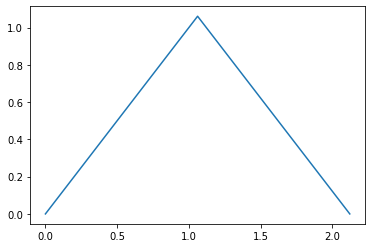

<Figure size 432x288 with 0 Axes>

In [5]:
# prove initial v shape
v_case = cosserat_rod(False, False, 2)
plt.plot(v_case.positions[2], v_case.positions[0])
plt.figure()
# test rotations
a = np.array([[[1, 1], [0, 0], [0, 0]], \
              [[0, 0], [1, 1], [0, 0]], \
              [[0, 0], [0, 0], [1, 1]]])
b = v_case.rotate_rodrigues(a, np.pi/2, [[0.0, 0.0], [0.1, 0.1], [0.0, 0.0]])
v_case.inverse_rotate(a, b)

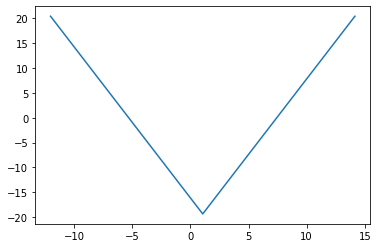

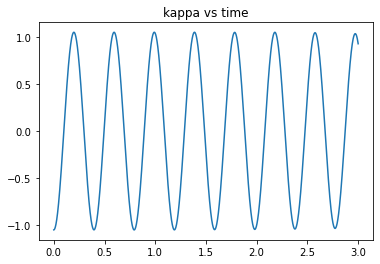

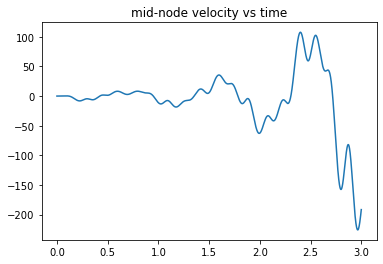

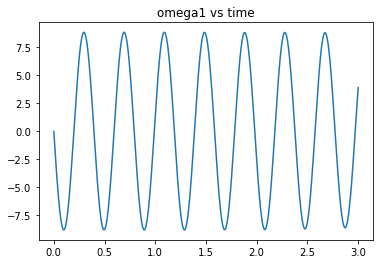

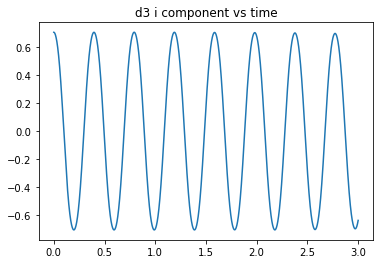

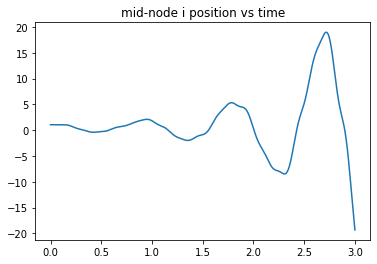

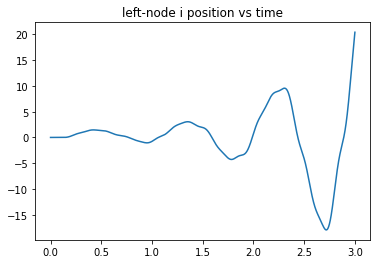

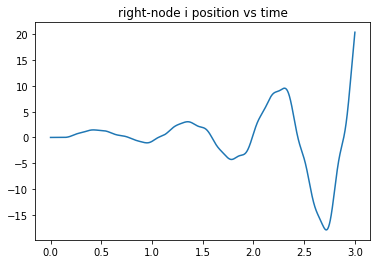

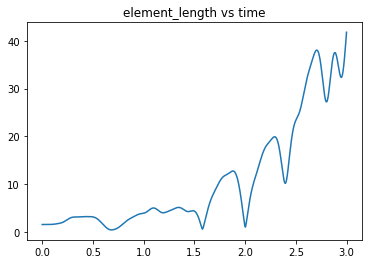

In [9]:
# Milestone 2 - using 2 elements only
v_case = cosserat_rod(False, False, 2)
t_total = 3
dt = 3E-4
ext_force = np.zeros((3, v_case.n_nodes))
ext_couples = np.zeros((3, v_case.n_elements))
final_pos, position_history = v_case.run(ext_force, ext_couples, t_total, dt)
time_history = np.arange(0, t_total, dt)

plt.figure()
plt.plot(final_pos[2], final_pos[0])
plt.figure()
plt.plot(time_history, v_case.kappa_history[0])
plt.title("kappa vs time")
plt.figure()
plt.title("mid-node velocity vs time")
plt.plot(time_history, v_case.vel_history[0, 1, :])
plt.figure()
plt.title("omega1 vs time")
plt.plot(time_history, v_case.omega_history[0])
plt.figure()
plt.title("d3 i component vs time")
plt.plot(time_history, v_case.director_history)
plt.figure()
plt.title("mid-node i position vs time")
plt.plot(time_history, v_case.position_history[0, 1, :])
plt.figure()
plt.title("left-node i position vs time")
plt.plot(time_history, v_case.position_history[0, 0, :])
plt.figure()
plt.title("right-node i position vs time")
plt.plot(time_history, v_case.position_history[0, 2, :])
plt.figure()
plt.title("element_length vs time")
plt.plot(time_history, v_case.length_history)

In [ ]:
import pickle as pk
filename = "milestone2_2elems.dat"
file = open(filename, "wb")
pk.dump(position_history, file)
file.close()

In [ ]:
# Milestone 1
stretch_case = cosserat_rod(2)
t_total = 10
dt = 3E-4
ext_force = np.zeros((3, stretch_case.n_nodes))
ext_force[0, -1] = 15
ext_couples = np.zeros((3, stretch_case.n_elements))
final_pos, position_history = stretch_case.run(ext_force, ext_couples, t_total, dt)

time_history = np.arange(0, t_total, dt)
plt.plot(time_history, position_history[-1,0,:])
plt.figure()
plt.plot(time_history, position_history[-1,-1,:])
print()
print('Average end displacement (m): ', end = '')
print(np.mean(position_history[-1,-1,:]-position_history[-1,-1, 0]))
print()

In [ ]:
stretch_case = cosserat_rod(1)
t_total = 100
dt = 3E-4
ext_force = np.zeros((3, stretch_case.n_nodes))
ext_force[-1, -1] = 15
ext_couples = np.zeros((3, stretch_case.n_elements))
final_pos, position_history = stretch_case.run(ext_force, t_total, dt)

time_history = np.arange(0, t_total, dt)
plt.plot(time_history, position_history[-1,0,:])
plt.figure()
plt.plot(time_history, position_history[-1,-1,:])
print()
print('Average end displacement (m): ', end = '')
print(np.mean(position_history[-1,-1,:]-position_history[-1,-1, 0]))
print()

In [ ]:
print(position_history.shape)

In [ ]:
import pickle as pk
filename = "milestone2_2elems.dat"
file = open(filename, "wb")
pk.dump(position_history, file)
file.close()